##사용할 패키지 불러오기

In [1]:
import keras
import numpy as np


from keras import optimizers



from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, SimpleRNN
from statsmodels.tsa.arima_process import arma_generate_sample
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline


Using TensorFlow backend.


In [0]:
# Epochs 전에 학습을 한 경우, 미리 멈출 수 있음
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)


## 1. MLP 모델

## 데이터 생성

In [0]:
np.random.seed(12313)

In [0]:
# [0, 1, 2, 3] , window_size = 2      =>   [ [0, 1], [1, 2], [2, 3] ]
def create_dataset(signal_data, window_size=1):
    dataX, dataY = [], []
    for i in range(len(signal_data)-window_size):
        dataX.append(signal_data[i:(i+window_size)])
        dataY.append(signal_data[i + window_size])
    return np.array(dataX), np.array(dataY)

In [0]:
# arima 파라미터 설정
arparams = np.array([.75, -.25])
maparams = np.array([.65, .35])
ar = np.r_[1, -arparams] # add zero-lag and negate
ma = np.r_[1, maparams] # add zero-lag

In [0]:
signal_data = arma_generate_sample(ar, ma, 10000)   # arima 데이터 생성
signal_data = signal_data[7000: ]

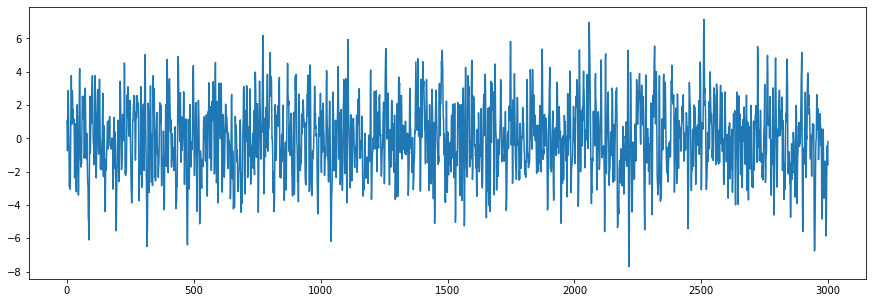

In [7]:
plt.figure(figsize=(15, 5))
plt.plot(signal_data)
plt.show()

## 데이터 전처리

In [0]:
# MinMaxScalar
maxValue = np.max(signal_data)
minValue = np.min(signal_data)
signal_data = (signal_data - minValue) / (maxValue - minValue)

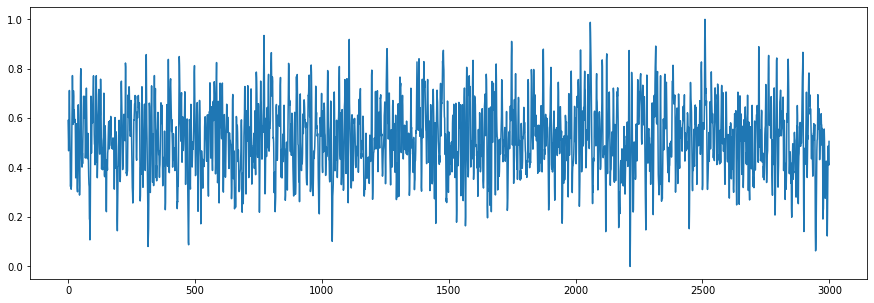

In [9]:
plt.figure(figsize=(15, 5))
# plt.plot(signal_data[0:300])
plt.plot(signal_data)
plt.show()

In [0]:
# 데이터 분리
train = signal_data[0:2400]
val = signal_data[2400:2700]
test = signal_data[2700:]

In [11]:
window_size = 5
# 데이터셋 생성
x_train, y_train = create_dataset(train, window_size)
x_val, y_val = create_dataset(val, window_size)
x_test, y_test = create_dataset(test, window_size)
print(y_train[0 : 5])

[0.7122207  0.60639185 0.53468616 0.46901136 0.32423224]


## MLP 모델 구성 및 생성

In [12]:

model1 = Sequential()
model1.add(Dense(32, input_dim = window_size, activation = 'relu'))
model1.add(Dense(16, activation = 'relu'))
model1.add(Dense(8, activation = 'relu'))
model1.add(Dense(4, activation = 'relu'))
model1.add(Dense(1))

model1.summary()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                192       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________


In [13]:
model1.compile(optimizer = optimizers.Adam(lr = 0.001), loss = 'mean_squared_error')

In [14]:
hist = model1.fit(x_train, y_train, epochs = 500, 
                  batch_size = 16, shuffle = False, callbacks=[es], validation_data = (x_val, y_val))
# hist = model1.fit(x_train, y_train, epochs = 500, 
#                   batch_size = 16, validation_data=(x_val, y_val), 
#                   shuffle = False, callbacks=[es])




Train on 2395 samples, validate on 295 samples
Epoch 1/500





2395/2395 [==============================] - 1s 433us/step - loss: 0.2487 - val_loss: 0.1732
Epoch 2/500
2395/2395 [==============================] - 0s 77us/step - loss: 0.1296 - val_loss: 0.0956
Epoch 3/500
2395/2395 [==============================] - 0s 81us/step - loss: 0.0720 - val_loss: 0.0523
Epoch 4/500
2395/2395 [==============================] - 0s 78us/step - loss: 0.0420 - val_loss: 0.0308
Epoch 5/500
2395/2395 [==============================] - 0s 77us/step - loss: 0.0283 - val_loss: 0.0214
Epoch 6/500
2395/2395 [==============================] - 0s 84us/step - loss: 0.0230 - val_loss: 0.0178
Epoch 7/500
2395/2395 [==============================] - 0s 82us/step - loss: 0.0212 - val_loss: 0.0166
Epoch 8/500
2395/2395 [==============================] - 0s 85us/step - loss: 0.0207 - val_loss: 0.0162
Epoch 9/500
2395/2395 [==============================] - 0s 83us/step - loss: 0.0206 - val_loss: 0.0160
Epoch 10

## MLP 모델 평가

In [0]:
# 6. 모델 평가하기
trainScore = model1.evaluate(x_train, y_train, batch_size=16, verbose=0)
print('Train Score: ', trainScore)

testScore = model1.evaluate(x_test, y_test, batch_size=16, verbose=0)
print('Test Score: ', testScore)


Train Score:  0.00433750887496673
Test Score:  0.005043870703143588


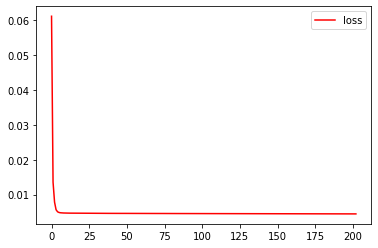

In [0]:
plt.plot(hist.history['loss'], c = 'r', label = 'loss')
plt.legend(loc = 'best')
plt.show()


In [0]:
# 모델 평가
model1_pred = model1.predict(x_test, batch_size = 16)
print(model1_pred[0:10])

[[0.41371465]
 [0.40947044]
 [0.5035248 ]
 [0.42232707]
 [0.44429746]
 [0.44030073]
 [0.6222296 ]
 [0.49696994]
 [0.50995255]
 [0.495098  ]]


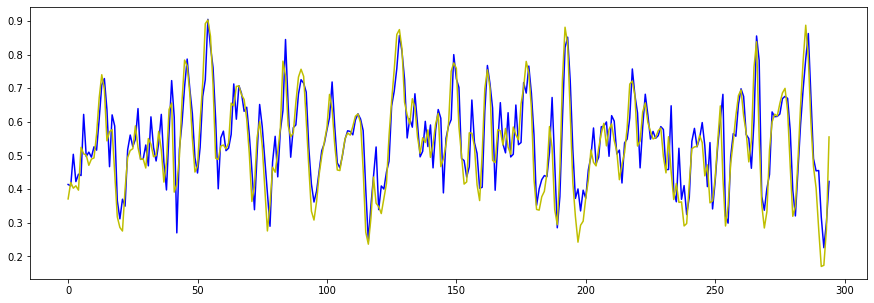

In [0]:
plt.figure(figsize = (15, 5))
plt.plot(model1_pred, 'b')
plt.plot(y_test, 'y')
plt.show()

# 2. LSTM 모델

## 데이터셋 생성 및 전처리

In [0]:
# window_size = 10
# # 데이터셋 생성
# x_train, y_train = create_dataset(train, window_size)
# x_test, y_test = create_dataset(test, window_size)

In [0]:
# 데이터셋 전처리
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)


## 손실 이력 저장 클래스

In [0]:
class CustomHistory(keras.callbacks.Callback):
    def __init__(self):
        self.train_loss = []
        self.val_loss = []
        
    def on_epoch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))


## LSTM 모델 생성

In [0]:
history = CustomHistory() # 손실 이력 객체 생성
def fit_lstm(x_train, y_train, x_val, batch_size, nb_epoch, neurons):
  import time
  from time import strftime
  start_time = time.time()
  model = Sequential()
#   LSTM(output_dim, input_shape = ((window_size, input_dim)), stateful=True) [LSTM 상태유지 스택 쌓기]
#   for i in range(3):
#       model.add(LSTM(16, batch_input_shape=(batch_size, x_train.shape[1], x_train.shape[2]), stateful=True, return_sequences=True))
#   model.add(LSTM(neurons, stateful=True, batch_input_shape=(batch_size, x_train.shape[1], x_train.shape[2]), return_sequences = False))

  model.add(LSTM(neurons, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences = False))
  model.add(Dense(1))
  print(model.summary())
  model.compile(loss='mean_squared_error', optimizer='adam')
  model.fit(x_train, y_train, epochs=nb_epoch, batch_size=batch_size, verbose=1, shuffle=False, callbacks=[history, es], validation_data = (x_val, y_val))
  
#   for i in range(nb_epoch): [상태유지 사용할 때 model의 상태를 reset하기 위해 사용]
#       temp_time = time.time()
#       model.fit(x_train, y_train, epochs=1, batch_size=batch_size, verbose=0, shuffle=False, callbacks=[history])
#       model.reset_states()
#       print(str(i + 1) + ' epoch \n걸린 시간(second) : ', time.time() - temp_time)
  print('\n걸린 시간(second) : ', time.time() - start_time)
  return model

In [0]:
# 5. 모델 학습시키기
num_epochs = 500

model2 = fit_lstm(x_train, y_train, x_val, 16, num_epochs, 8)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 8)                 320       
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
None
Train on 2395 samples, validate on 295 samples
Epoch 1/500
2395/2395 [==============================] - 3s 1ms/step - loss: 0.1110 - val_loss: 0.0240
Epoch 2/500
2395/2395 [==============================] - 1s 333us/step - loss: 0.0185 - val_loss: 0.0233
Epoch 3/500
2395/2395 [==============================] - 1s 322us/step - loss: 0.0179 - val_loss: 0.0225
Epoch 4/500
2395/2395 [==============================] - 1s 309us/step - loss: 0.0174 - val_loss: 0.0218
Epoch 5/500
2395/2395 [========================

## LSTM 모델 평가

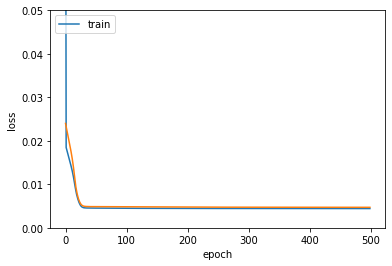

In [0]:
# 5. 학습과정 살펴보기
plt.plot(history.train_loss)
plt.plot(history.val_loss)

plt.ylim(0.0, 0.05)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [0]:
# 6. 모델 평가
trainScore = model2.evaluate(x_train, y_train, batch_size=1, verbose=0)
print('Train Score: ', trainScore)

testScore = model2.evaluate(x_test, y_test, batch_size=1, verbose=0)
print('Test Score: ', testScore)


Train Score:  0.004448611824923393
Test Score:  0.005027665996263794


In [0]:
# 7. 모델 사용 -- 바로 다음 값 예측
model2_pred = model2.predict(x_test, batch_size = 1)


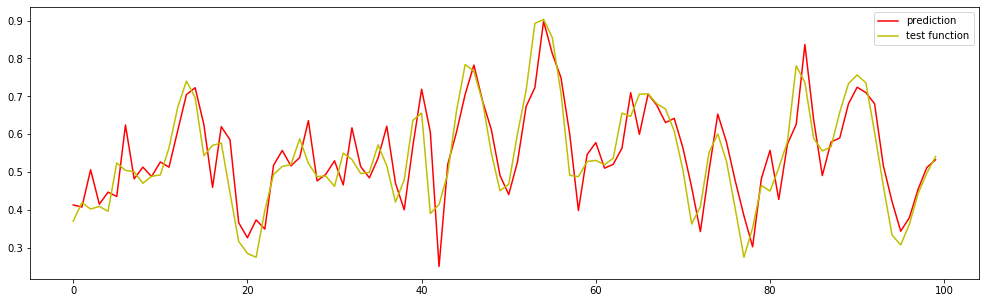

In [0]:
plt.figure(figsize=(17,5))
plt.plot(model2_pred[0 : 100],'r',label="prediction")
plt.plot(y_test[0 : 100], 'y', label="test function")
plt.legend()
plt.show()

## RNN 모델

In [0]:
model3 = Sequential()
model3.add(SimpleRNN(8, input_shape = (x_train.shape[1], x_train.shape[2])))
model3.add(Dense(1))

In [0]:
model3.compile(loss='mse', optimizer = 'adam')

In [0]:
history = model3.fit(x_train, y_train, epochs=500, shuffle = False, callbacks = [es],  validation_data = (x_val, y_val))

Train on 2395 samples, validate on 295 samples
Epoch 1/500
2395/2395 [==============================] - 3s 1ms/step - loss: 0.3717 - val_loss: 0.0476
Epoch 2/500
2395/2395 [==============================] - 0s 64us/step - loss: 0.0250 - val_loss: 0.0292
Epoch 3/500
2395/2395 [==============================] - 0s 63us/step - loss: 0.0226 - val_loss: 0.0270
Epoch 4/500
2395/2395 [==============================] - 0s 64us/step - loss: 0.0208 - val_loss: 0.0248
Epoch 5/500
2395/2395 [==============================] - 0s 63us/step - loss: 0.0192 - val_loss: 0.0228
Epoch 6/500
2395/2395 [==============================] - 0s 63us/step - loss: 0.0176 - val_loss: 0.0210
Epoch 7/500
2395/2395 [==============================] - 0s 63us/step - loss: 0.0163 - val_loss: 0.0193
Epoch 8/500
2395/2395 [==============================] - 0s 62us/step - loss: 0.0150 - val_loss: 0.0178
Epoch 9/500
2395/2395 [==============================] - 0s 65us/step - loss: 0.0139 - val_loss: 0.0164
Epoch 10/500
2395/

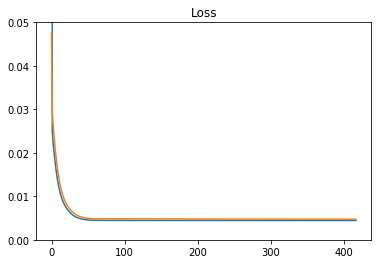

In [0]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylim(0, 0.05)
plt.title("Loss")
plt.show()

In [0]:
# 6. 모델 평가
trainScore = model3.evaluate(x_train, y_train, batch_size=1, verbose=0)
print('Train Score: ', trainScore)

testScore = model3.evaluate(x_test, y_test, batch_size=1, verbose=0)
print('Test Score: ', testScore)

Train Score:  0.0044256141014253
Test Score:  0.005031981853311814


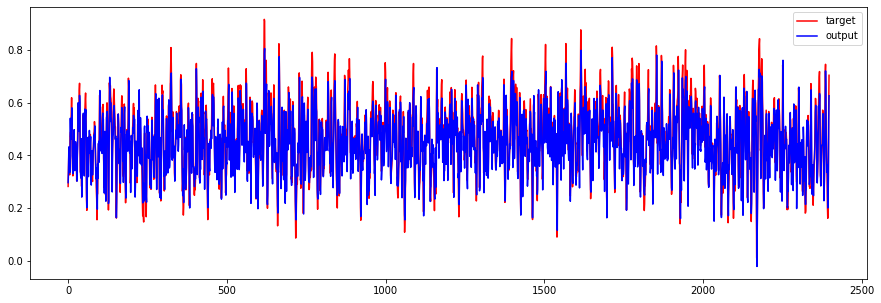

In [0]:
plt.figure(figsize = (15, 5))
plt.plot(y_train, 'r', label="target")
plt.plot(model3.predict(x_train), 'b', label="output")
plt.legend()
plt.show()

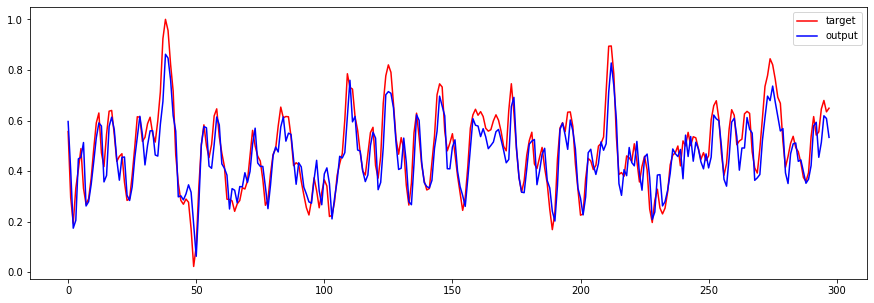

In [0]:
plt.figure(figsize = (15, 5))
plt.plot(y_test, 'r', label="target")
plt.plot(model3.predict(x_test), 'b', label="output")
plt.legend()
plt.show()

# 정규분포 데이터 추가

In [0]:
signal_data = arma_generate_sample(ar, ma, 10000)   # arima 데이터 생성
signal_data = signal_data[7000: ]
normal_data = np.random.normal(size = 3000)
print(normal_data[0:10])

[ 0.96452491  0.65435823  2.02144217 -2.11299271 -0.99905367 -1.90837246
  0.35887515  0.20014339 -0.96832576  0.87207278]


In [0]:
# [0, 1, 2, 3] , window_size = 2      =>   [ [0, 1], [1, 2], [2, 3] ]
def create_dataset2(signal_data, normal_data, window_size=1):
    dataX, dataY = [], []
    for i in range(len(signal_data)-window_size):
        dataX.append(list(zip(signal_data[i:(i+window_size)], normal_data[i:(i+window_size)])))
        dataY.append(signal_data[i + window_size])
    return np.array(dataX), np.array(dataY)

In [0]:
# MinMaxScalar
maxValue = np.max(signal_data)
minValue = np.min(signal_data)
signal_data = (signal_data - minValue) / (maxValue - minValue)


In [0]:
# 데이터 분리
train = signal_data[0:2400]
val = signal_data[2400:2700]
test = signal_data[2700:]

In [0]:
window_size = 5 # 데이터셋 생성
x_train, y_train = create_dataset2(train, normal_data[0:2400], window_size)
x_val, y_val = create_dataset2(val, normal_data[2400 : 2700], window_size)
x_test, y_test = create_dataset2(test, normal_data[2700 :], window_size)

In [0]:
history = CustomHistory() # 손실 이력 객체 생성
def fit_lstm(x_train, y_train, batch_size, nb_epoch, neurons):
  import time
  from time import strftime
  start_time = time.time()
  
  
  
  model = Sequential()
  model.add(LSTM(neurons, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences = False))
  model.add(Dense(1))
  print(model.summary())
  model.compile(loss='mean_squared_error', optimizer='adam')
  model.fit(x_train, y_train, epochs=nb_epoch, batch_size=batch_size, verbose=1, shuffle=False, callbacks=[history, es], validation_data = (x_val, y_val))
  print('\n걸린 시간(second) : ', time.time() - start_time)
  return model

In [0]:
# 5. 모델 학습시키기
num_epochs = 200

model4 = fit_lstm(x_train, y_train, 16, num_epochs, 8)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 8)                 352       
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 9         
Total params: 361
Trainable params: 361
Non-trainable params: 0
_________________________________________________________________
None
Train on 2395 samples, validate on 295 samples
Epoch 1/200
2395/2395 [==============================] - 3s 1ms/step - loss: 0.0581 - val_loss: 0.0212
Epoch 2/200
2395/2395 [==============================] - 1s 315us/step - loss: 0.0250 - val_loss: 0.0203
Epoch 3/200
2395/2395 [==============================] - 1s 340us/step - loss: 0.0237 - val_loss: 0.0194
Epoch 4/200
2395/2395 [==============================] - 1s 302us/step - loss: 0.0224 - val_loss: 0.0184
Epoch 5/200
2395/2395 [========================

In [0]:
# 6. 모델 평가
trainScore = model4.evaluate(x_train, y_train, batch_size=1, verbose=0)
print('Train Score: ', trainScore)

testScore = model4.evaluate(x_test, y_test, batch_size=1, verbose=0)
print('Test Score: ', testScore)

Train Score:  0.006427356225605026
Test Score:  0.006480249343775216


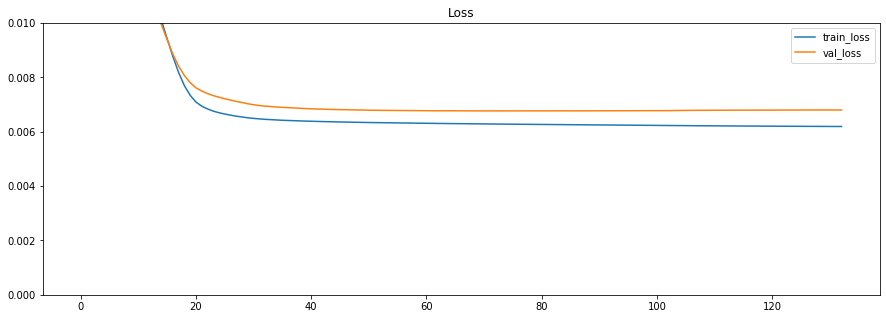

In [0]:
plt.figure(figsize=(15, 5))
plt.plot(history.train_loss,label = 'train_loss')
plt.plot(history.val_loss, label = 'val_loss')
plt.ylim(0, 0.01)
plt.legend()
plt.title("Loss")

plt.show()

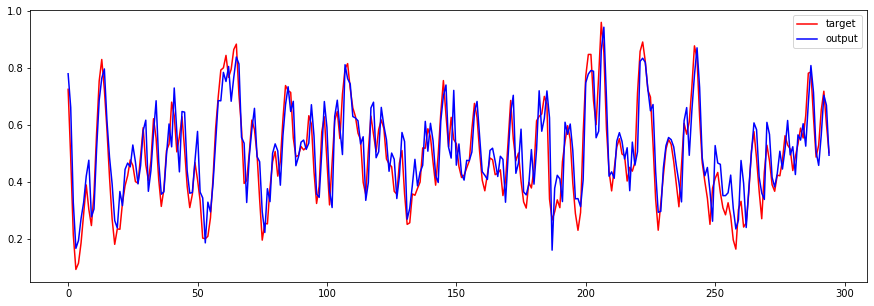

In [0]:
plt.figure(figsize = (15, 5))
plt.plot(y_test, 'r', label="target")
plt.plot(model4.predict(x_test), 'b', label="output")
plt.legend()
plt.show()